### 数据介绍
2023.10.25

In [1]:
import math

import pandas as pd

df = pd.read_csv('E:\\论文\交通流\\AE\\trafiicflow_prediction\\TrafficFlowPrediction\\data\\train.csv')
print(df.head())


         5 Minutes  Lane 1 Flow (Veh/5 Minutes)  # Lane Points  % Observed
0  04/01/2016 0:00                           12              1         100
1  04/01/2016 0:05                           13              1         100
2  04/01/2016 0:10                           11              1         100
3  04/01/2016 0:15                           13              1         100
4  04/01/2016 0:20                           10              1         100


5 Minutes：表示时间间隔，每个观测点的数据采集时间段为5分钟
Lane 1 Flow (Veh/5 Minutes)：表示车道1的流量，以5分钟内通过的车辆数进行计算
Lane Points：可以理解为车道的数量或车道点的数量
% Observed：表示观察到的车辆百分比。

### 下面是根据原有代码，尝试跟写一遍代码弄清楚代码原理

Dense：该模块**提供了全连接层的实现**。全连接层是神经网络中最基本的层之一，将输入数据与权重矩阵相乘，并应用激活函数来生成输出。

Dropout：该模块提供了在训练过程中添加随机失活的功能。随机失活**是一种正则化技术**，可通过在每个训练步骤中随机关闭一部分神经元来减少过拟合。

Activation：该模块**提供了各种激活函数的实现**，例如ReLU、sigmoid和softmax等。激活函数在神经网络中引入非线性性质，使其能够学习更复杂的模式。

LSTM 和 GRU：这两个模块分别实现了长短期记忆（LSTM）和门控循环单元（GRU）的循环神经网络（RNN）层。LSTM和GRU是RNN的变体，专门处理序列数据，并且能够捕捉长期依赖关系。

Sequential：该模块**定义了一个顺序模型**，可以按照顺序将各层逐个添加到模型中。这是最常用的模型类型，**特别适用于堆叠多个神经层的情况**。

In [2]:
# 先写model.py，先定义好模型
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, GRU
from keras.models import Sequential

D:\Lenovo\application\anaconda3\envs\dpstudy\lib\site-packages\requests\__init__.py:114: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  RequestsDependencyWarning,


对下面get_lstm中注释的一个解释
units:第一个说明的类型，表明是int的列表，列表中包含了输入、输出和隐藏单元的数量

In [3]:
def get_lstm(units):
    """
    LSTM
    # Arguments
        units:List(int), number of input, output and hidden units
    # Returns
        model:Model, nn model

    """
    model = Sequential()
    model.add(LSTM(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(LSTM(units[2]))
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model

In [4]:
# 创建GRU的模型
def get_gru(units):
    """
    GRU
    # Arguments
        units:List(int), number of input, output and hidden units
    Return
        model: Model, nn model
    """

    model = Sequential()
    model.add(GRU(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(GRU(units[2]))
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model

In [5]:
# 创建SAE模型，这只是一个自编码
def _get_sae(inputs, hidden, output):
    """
    SAE
    # Arguments
        inputs:Integer, number of input units
        hidden:Integer, number of hidden units
        output:Integer, number of output units
    # Return
        model:Model, nn model

    """
    model = Sequential()
    model.add(Dense(hidden, input_dim=inputs, name='hidden'))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(output, activation='sigmoid'))

In [6]:
# 堆叠自编码
def get_saes(layers):
    """
    SAES
    # Arguments
        layers:List(int), number of input, output and hidden units
    # Returns
        models:List(Model), List of SAE and SAEs
    """
    sae1 = _get_sae(layers[0], layers[1], layers[-1])
    sae2 = _get_sae(layers[1], layers[2], layers[-1])
    sae3 = _get_sae(layers[2], layers[3], layers[-1])

    saes = Sequential()
    saes.add(Dense(layers[1], input_dim=layers[0], name='hidden1'))
    saes.add(Activation('sigmoid'))
    saes.add(Dense(layers[2], name='hidden2'))
    saes.add(Activation('sigmoid'))
    saes.add(Dense(layers[3], name='hidden3'))
    saes.add(Activation('sigmoid'))
    saes.add(Dropout(0.2))
    saes.add(Dense(layers[4], activation='sigmoid'))

    models = [sae1, sae2, sae3, saes]
    return models

In [7]:
# 训练train.py
import sys
import warnings
import argparse
import numpy as np
import pandas as pd
from model import model
from keras.models import Model
from keras.callbacks import  EarlyStopping
warnings.filterwarnings("ignore")


In [8]:
# 引入process_data
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def process_data(train, test, lags):
    """
    # Arguments
        train:String, name of .csv train file
        test:String, name of .csv test file
        lags:integer, time lag
    # Returns
        X_train:ndarray
        y_train:ndarray
        X_test:ndarray
        y_test:ndarray
        scaler:StandardScaler
    """
    attr = 'Lane 1 Flow (Veh/5 Minutes)'
    df1 = pd.read_csv(train, encoding='utf-8').fillna(0)
    df2 = pd.read_csv(test, encoding='utf-8').fillna(0)

    scaler = MinMaxScaler(feature_range=(0,1)).fit(df1[attr].values.reshape(-1, 1))
    flow1 = scaler.transform(df1[attr].values.reshape(-1,1)).reshape(1,-1)[0]
    flow2 = scaler.transform(df2[attr].values.reshape(-1,1)).reshape(1,-1)[0]

    train, test = [], []
    for i in range(lags, len(flow1)):
        train.append(flow1[i-lags:i+1])
    for i in range(lags, len(flow2)):
        test.append(flow2[i - lags:i + 1])

    train = np.array(train)
    test = np.array(test)
    np.random.shuffle(train)

    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = test[:,:-1]
    y_test = test[:,-1]

    return X_train, y_train, X_test, y_test, scaler

"""
上述操作进行了时间滞后处理，然后划分好训练集和测试集。
"""

'\n上述操作进行了时间滞后处理，然后划分好训练集和测试集。\n'

In [10]:
def MAPE(y_true, y_pred):
    '''
    计算平均绝对误差
    '''
    y = [x for x in y_true if x>0]
    y_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i]>0]

    num = len(y_pred)
    sums = 0
    for i in range(num):
        tmp = abs((y[i] - y_pred[i])/y[i])
        sums += tmp

    mape = sums *(100/num)
    return mape

In [11]:
from sklearn import metrics


def eva_regress(y_true, y_pred):
    '''
    评估预测结果
    '''
    # 获取mape
    mape = MAPE(y_true, y_pred)
    vs = metrics.explained_variance_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print('explained_variance_socre:%f' % vs)
    print('mape:%f%%' % mape)
    print('mae:%f' % mae)
    print('rmse:%f' % math.sqrt(mse))
    print('r2:%f' % r2)


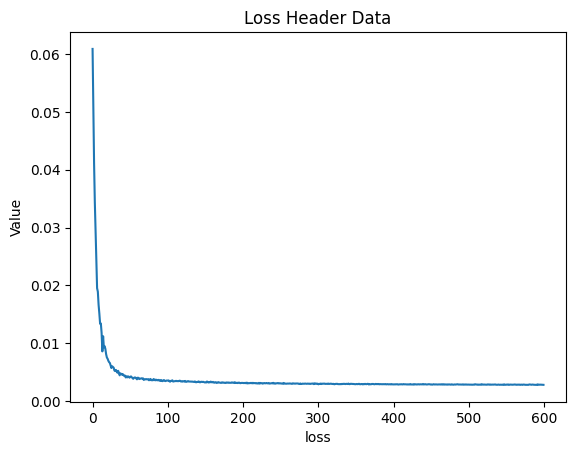

In [14]:
# 绘制Loss图

import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('E:\\论文\\交通流\\AE\\trafiicflow_prediction\\TrafficFlowPrediction\\model\\saes loss.csv')


# 绘制loss表头一栏的数据
plt.plot(df['loss'])
plt.xlabel('loss')
plt.ylabel('Value')
plt.title('Loss Header Data')
plt.show()